In [86]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from rusenttokenize import ru_sent_tokenize
import pymorphy3

from itertools import chain
from collections import Counter
import re

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
MAX_WORDS = 5000

In [87]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preprocessing

In [88]:
# Загрузка датасета с отзывами
df = pd.read_csv('data_reviews.csv', 
                 names=['reviewText', 'label'], 
                 encoding='windows_1251')

In [89]:
df.head()

,reviewText,label
0,Впервые я взяла рассрочку(никогда ничего не бр...,1
1,"Только что увидела дешевый флэш накопитель, оп...",3
2,С данным интернет-магазином я познакомился год...,5
3,"Наша жизнь не стоит на месте. Время идет, и вс...",4
4,Интернет-магазин Ozon.ru .Этот интернет магази...,5


In [90]:
def text_preprocess(s: str) -> str:
    """
    Первоначальная обработка текста, перевод букв нижний регистр,
    удаление чисел, символов переноса строки
    """
    preprocessed_text = []
    # удаление пробелов в начале и в конце строки
    s = s.strip()
    # приведение букв в нижный регистр
    s = s.lower()
    # отделение пробелами символов ".", ",", "!", "?"
    s = re.sub(r"([.,!?])", r" \1 ", s)
    # заменить на пробелы все символы, кроме а-я, А-Я, ".", ",", "!", "?"
    s = re.sub(r"[^а-яА-Я.,!?]+", " ", s)
    # убрать дублирующие пробелы
    s = re.sub(r"\s{2,}", " ", s)
    # убрать пробелы в начале и в конце строки
    s = s.strip()
    
    return s


def tokens_preprocess(s: str) -> str:
    """
    Разбиение отзыва на токены (лемматизация) 
    """
    
    # Токены с удалением стоп-слов
    tokens = ' '.join([morph.parse(token)[0].normal_form 
                 for token in word_tokenize(s) if 
                (token not in punctuation_marks and token 
                 not in stop_words)])
    
    return tokens


def tokens_preprocess_with_stop(s: str) -> str:
    """
    Разбиение отзыва на токены (лемматизация)
    """
    
    # Токены с удалением стоп-слов
    tokens = ' '.join([morph.parse(token)[0].normal_form 
                 for token in word_tokenize(s) 
                 if token not in punctuation_marks])
    
    return tokens


def sentence_preprocess(s: str) -> str:
    tokenizer = ru_sent_tokenize(s)
    review = []
    
    for sent in tokenizer:
        sent = [morph.parse(word)[0].normal_form for word in sent.split() 
                    if word not in punctuation_marks]
        if sent:   
            review.append(sent)
            
    return review

In [91]:
morph = pymorphy3.MorphAnalyzer()
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', \
                     '...', '«', '»', ';', '–', '--']

stop_words = stopwords.words("russian")


Текст отзывов преобразуем в два формата токенов, с удалением и без стоп-слов.

In [93]:
df['reviewText'] = df.reviewText.transform(
                        lambda x: text_preprocess(x))

df['Tokens'] = df.reviewText.apply(
                        lambda x: tokens_preprocess(x))
df['Tokens_stop'] = df.reviewText.apply(
                        lambda x: tokens_preprocess_with_stop(x))

In [94]:
df = df.drop_duplicates().reset_index(drop=True)

In [95]:
df['Sentences'] = df.reviewText.apply(
                        lambda x: sentence_preprocess(x))

In [85]:
df.head()

,reviewText,Tokens,Tokens_stop,Sentences,target
0,впервые я взяла рассрочку никогда ничего не бр...,впервые взять рассрочка брать доверие компания...,впервые я взять рассрочка никогда ничего не бр...,"[[впервые, я, взять, рассрочка, никогда, ничег...",0
1,"только что увидела дешевый флэш накопитель , о...",увидеть дешёвый флэш накопитель оплатить потре...,только что увидеть дешёвый флэш накопитель опл...,"[[только, что, увидеть, дешёвый, флэш, накопит...",0
2,с данным интернет магазином я познакомился год...,данные интернет магазин познакомиться год наве...,с данные интернет магазин я познакомиться год ...,"[[с, данные, интернет, магазин, я, познакомить...",1
3,"наша жизнь не стоит на месте . время идет , и ...",наш жизнь стоить место время идти меняться мен...,наш жизнь не стоить на место время идти и всё ...,"[[наш, жизнь, не, стоить, на, место], [время, ...",1
4,интернет магазин . . этот интернет магазин зна...,интернет магазин интернет магазин знак очень д...,интернет магазин этот интернет магазин знак я ...,"[[интернет, магазин], [этот, интернет, магазин...",1


## EDA

In [96]:
def plot_text(ax: plt.Axes):
    """
    Выводит процентные значения на столбчатой диаграмме.
    
    Параметры:
        ax (plt.Axes): Объект Axes, на котором отображается 
        столбчатая диаграмма.
    """
    # Перебираем каждый столбец на диаграмме
    for p in ax.patches:
        # Вычисляем процентное значение высоты столбца
        percentage = '{:.1f}%'.format(p.get_height())
        # Аннотируем столбец с процентным значением
        ax.annotate(
            percentage,  # Текст аннотации
            # Координаты аннотации (по центру столбца)
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # Выравнивание текста
            ha='center',
            va='center',
            # Смещение текста относительно координаты
            xytext=(0, 10),
            # Использование смещения в "точках" (points)
            textcoords='offset points',
            fontsize=10
        )

        
def plot_bars(data: pd.DataFrame, target: str):
    """
    Выводит столбчатую диаграмму для данных DataFrame.
    
    Параметры:
        data: DataFrame с данными для построения столбчатой диаграммы.
    """
    # Вычисляем процентное распределение меток
    norm_target = (data[target]
                  .value_counts(normalize=True)
                  .mul(100)
                  .rename('percent')
                  .reset_index())
          
   
    plt.figure(figsize=(9, 6))
    # Строим столбчатую диаграмму
    ax = sns.barplot(x=target, 
                     y='percent', 
                     data=norm_target, 
                     palette='flare')

    # Добавляем процентные значения к столбцам
    plot_text(ax)
    
        
    # Устанавливаем заголовок графика
    ax.set_title('Оценки пользователей', fontsize=14)
    # Устанавливаем подпись оси x
    ax.set_xlabel('Оценки пользователей', fontsize=12)
    # Устанавливаем подпись оси y
    ax.set_ylabel('Доля в процентах', fontsize=12)

    # Отображаем график
    plt.show()        

    

def generate_wordcloud(text: str):
    """
    Генерирует облако слов на основе входного текста.
    
    Параметры:
        text (str): Текст для создания облака слов.
    """
    
    wordCloud = WordCloud(width = 800, 
                          height = 800, 
                          random_state=RAND, 
                          background_color='black', 
                          colormap='Set2').generate(text)

    # Создаем фигуру для облака слов
    plt.figure(figsize=(10, 5))
    # Отображаем облако слов
    plt.imshow(wordCloud)
    # Убираем метки по осям x и y
    plt.xticks([])
    plt.yticks([])
    # Показываем облако слов
    plt.show()

В датасете присутсвует 14k+ отзывов клиентов онлайн магазина "Ozon", в качестве разметки отзывов использованы оценки \
самих же пользователей от 1 до 5 баллов.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14792 entries, 0 to 14791
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewText   14792 non-null  object
 1   label        14792 non-null  int64 
 2   Tokens       14792 non-null  object
 3   Tokens_stop  14792 non-null  object
 4   Sentences    14792 non-null  object
dtypes: int64(1), object(4)
memory usage: 577.9+ KB


In [98]:
df.describe(include=['object'])

,reviewText,Tokens,Tokens_stop,Sentences
count,14792,14792,14792,14792
unique,14792,14792,14792,14792
top,впервые я взяла рассрочку никогда ничего не бр...,впервые взять рассрочка брать доверие компания...,впервые я взять рассрочка никогда ничего не бр...,"[[впервые, я, взять, рассрочка, никогда, ничег..."
freq,1,1,1,1


### Распределение оценок пользователей

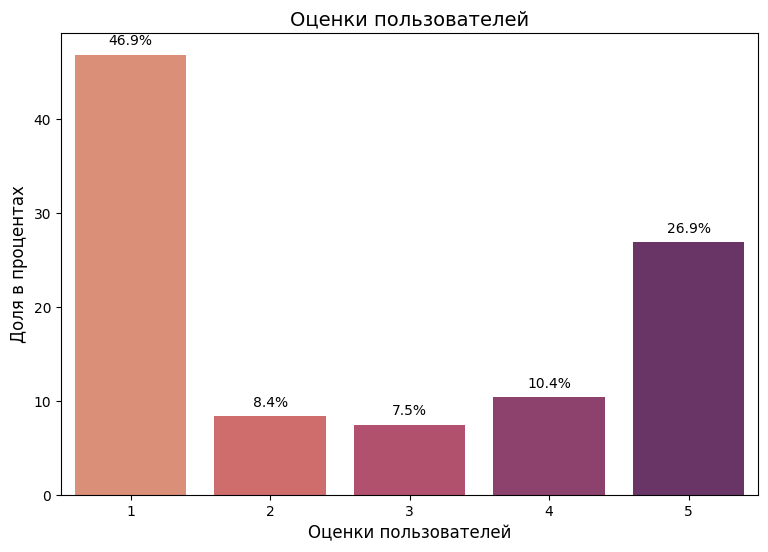

In [99]:
plot_bars(df, 'label')

В датасете преобладают резко негативные отзывы с оценкой 1.

В данной работе будет решаться задача определения тональности отзывов в формате: позитивный/негативный. \
Исходя из этого отзывы с оценками 1-3 принимаются за негативные (метка 0), 4,5 - позитивные (метка 1). 

In [100]:
df['target'] = df.label.apply(lambda x: 1 if int(x) > 3 else 0)
df = df.drop(columns='label', axis=1)

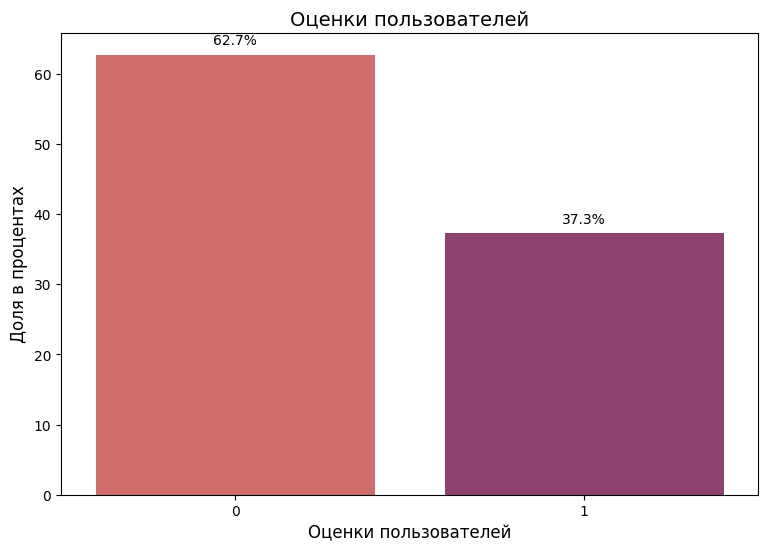

In [101]:
plot_bars(df, 'target')

Дисбаланс классов сохраняется в сторону негативных отзывов.

In [103]:
df.to_csv('PreprocessData_v_1.1.csv')

### Длина текстов

In [104]:
df_len = df.copy()
df_len.head()

,reviewText,Tokens,Tokens_stop,Sentences,target
0,впервые я взяла рассрочку никогда ничего не бр...,впервые взять рассрочка брать доверие компания...,впервые я взять рассрочка никогда ничего не бр...,"[[впервые, я, взять, рассрочка, никогда, ничег...",0
1,"только что увидела дешевый флэш накопитель , о...",увидеть дешёвый флэш накопитель оплатить потре...,только что увидеть дешёвый флэш накопитель опл...,"[[только, что, увидеть, дешёвый, флэш, накопит...",0
2,с данным интернет магазином я познакомился год...,данные интернет магазин познакомиться год наве...,с данные интернет магазин я познакомиться год ...,"[[с, данные, интернет, магазин, я, познакомить...",1
3,"наша жизнь не стоит на месте . время идет , и ...",наш жизнь стоить место время идти меняться мен...,наш жизнь не стоить на место время идти и всё ...,"[[наш, жизнь, не, стоить, на, место], [время, ...",1
4,интернет магазин . . этот интернет магазин зна...,интернет магазин интернет магазин знак очень д...,интернет магазин этот интернет магазин знак я ...,"[[интернет, магазин], [этот, интернет, магазин...",1


Количество слов и предложений в отзывах

In [107]:
df_len['words_count'] = df_len['Tokens_stop'].apply(
                            lambda x: len(x.split()))

df_len['sents_count'] = df_len['Sentences'].apply(
                            lambda x: len(x))

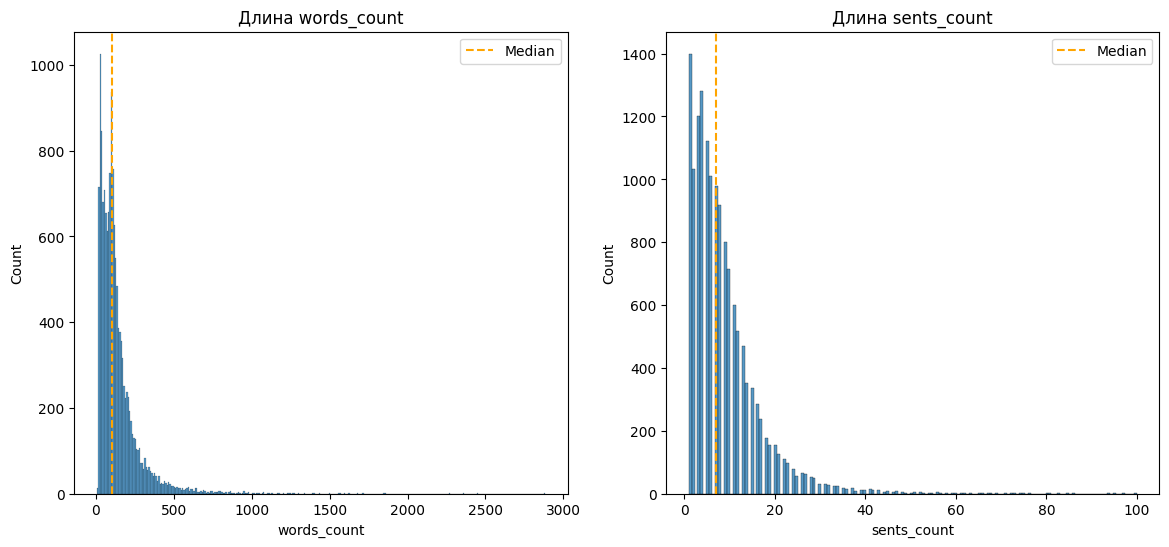

In [109]:
lst = ['words_count', 'sents_count']

# Построение гистограмм количества слов и предложений 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(lst):
    median = df_len[col].median()
    
    sns.histplot(df_len[col],
                     ax=axes[i]).set(title=f'Длина {col}')
    
    axes[i].axvline(median, 
                    linestyle='--', 
                    color='orange', 
                    label='Median')
    axes[i].legend()

Формы гистограмм схожи, логично что в отзывах с большим количеством предложений больше слов.

Оценим распределения количества слов и предложений в разрезе целевой переменной.

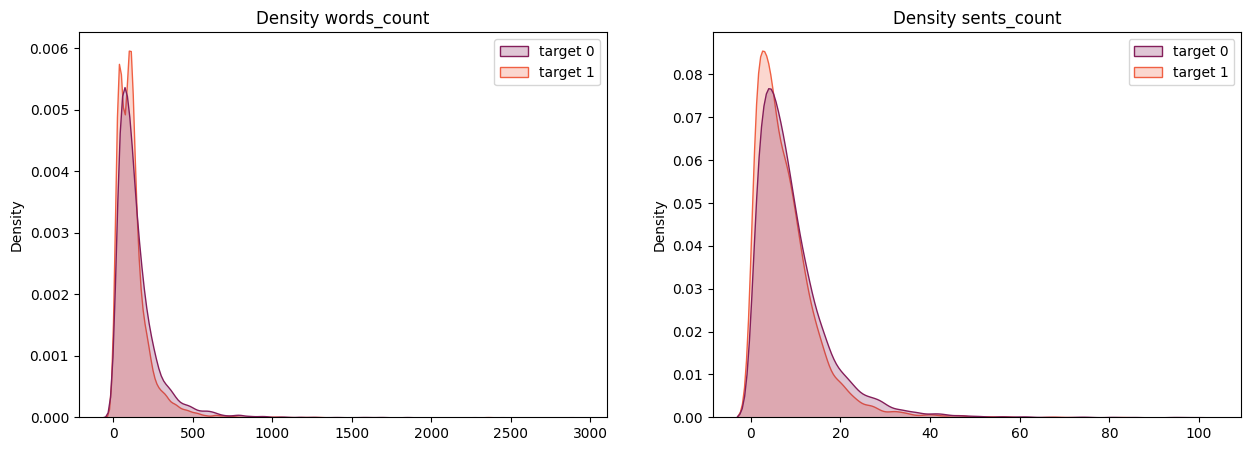

In [110]:
# Плотности распределения количества слов и предложений
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for i, col in enumerate(lst):
    sns.kdeplot({'target 0': df_len[df_len.target == 0][col],
                 'target 1': df_len[df_len.target == 1][col]},
                  common_norm=False,
                  palette='rocket',
                  shade=True,
                  ax=axes[i]).set_title('Density '+ col)


Распределения схожи, но в целом можно отметить что негативные отзывы содержат больше текста.

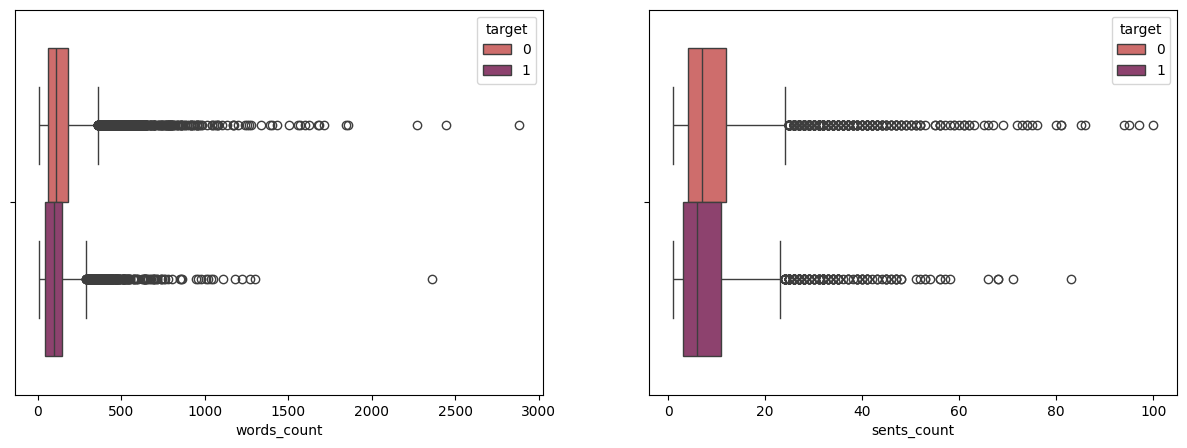

In [111]:
# Построение боксплотов
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for i, col in enumerate(lst):
    sns.boxplot(data=df_len, 
                x=col, 
                hue='target', 
                ax=axes[i], 
                palette='flare')

Боксплоты в данном случае более информативны и подтверждают вывод о большем количестве текста в негативных отзывах.

Длина отзывов (количестве символов)

In [112]:
df_len['length'] = df.reviewText.str.len()

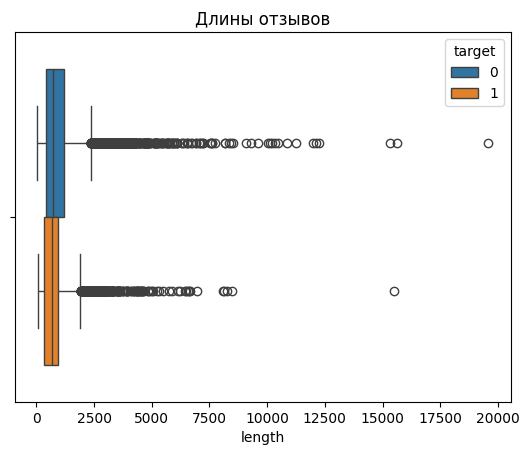

In [115]:
sns.boxplot(data=df_len, 
            x='length', 
            hue='target')

plt.title('Длины отзывов')
plt.show()

Картина такая же, как с количеством слов/предложений. Оценим среднюю длину слов и предложений в отзывах.

In [116]:
df_len['word_len'] = df_len.Tokens_stop.apply(
                    lambda x: np.mean([len(t) for t in x.split()]))

In [117]:
df_len[:3]

,reviewText,Tokens,Tokens_stop,Sentences,target,words_count,sents_count,length,word_len
0,впервые я взяла рассрочку никогда ничего не бр...,впервые взять рассрочка брать доверие компания...,впервые я взять рассрочка никогда ничего не бр...,"[[впервые, я, взять, рассрочка, никогда, ничег...",0,114,13,683,4.394737
1,"только что увидела дешевый флэш накопитель , о...",увидеть дешёвый флэш накопитель оплатить потре...,только что увидеть дешёвый флэш накопитель опл...,"[[только, что, увидеть, дешёвый, флэш, накопит...",0,152,8,1010,5.138158
2,с данным интернет магазином я познакомился год...,данные интернет магазин познакомиться год наве...,с данные интернет магазин я познакомиться год ...,"[[с, данные, интернет, магазин, я, познакомить...",1,92,8,621,5.163043


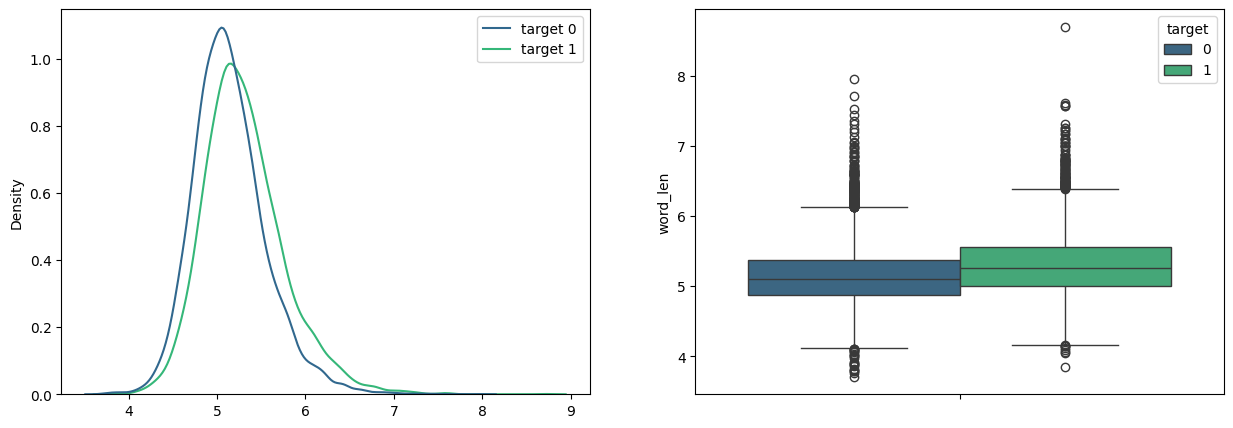

In [119]:
# Плотности распределения средней длины слова в отзыве

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': df_len[df_len.target == 0].word_len,
             'target 1': df_len[df_len.target == 1].word_len},
              common_norm=False,
              palette='viridis',
              ax=axes[0])

sns.boxplot(data=df_len, 
            y='word_len', 
            hue='target', 
            ax=axes[1], 
            palette='viridis')
plt.show()

Средняя длина слова в позитивном отзыве немного больше чем в негативном 

In [121]:
df_len['sent_len'] = df_len.Sentences.apply(
                    lambda rev: np.mean([len(''.join(sent)) for sent in rev]))

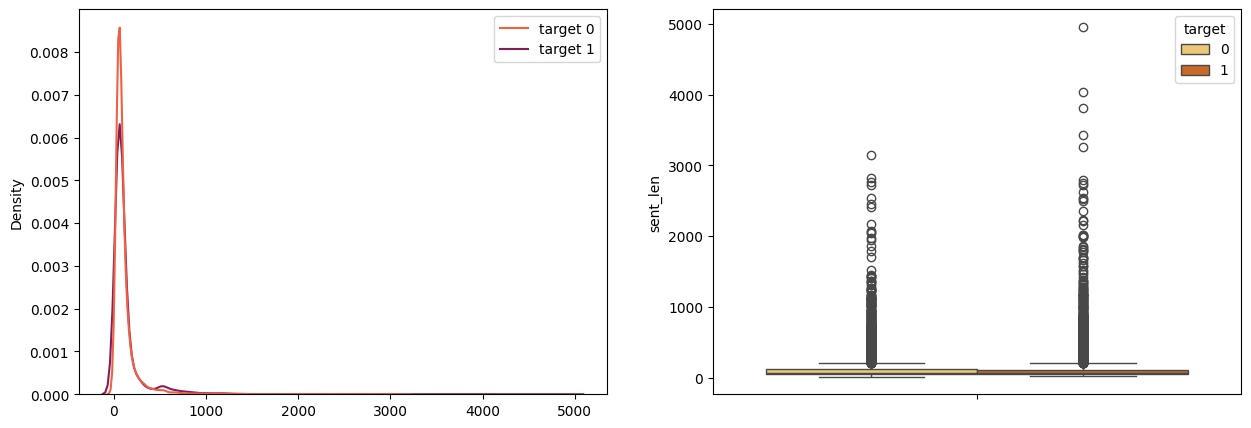

In [122]:
# Плотности распределения средней длины предложения в отзыве
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': df_len[df_len.target == 0].sent_len,
             'target 1': df_len[df_len.target == 1].sent_len},
              common_norm=False,
              palette='rocket_r',
              ax=axes[0])

sns.boxplot(data=df_len, 
            y='sent_len', 
            hue='target', 
            ax=axes[1], 
            palette='YlOrBr')
plt.show()

Ощутимой разницы в длинах предложений отзывов в разрезе целевой переменной нет

In [123]:
df_len.describe()

,target,words_count,sents_count,length,word_len,sent_len
count,14792.000000,14792.000000,14792.000000,14792.000000,14792.000000,14792.000000
mean,0.372566,137.109113,8.823350,903.322201,5.205183,123.200423
std,0.483504,139.497438,8.014031,910.413715,0.438057,198.965861
min,0.000000,6.000000,1.000000,41.000000,3.709677,12.000000
25%,0.000000,55.750000,4.000000,372.000000,4.911765,50.666667
50%,0.000000,103.000000,7.000000,679.000000,5.154335,70.535897
75%,1.000000,166.000000,12.000000,1093.000000,5.440860,114.407143
max,1.000000,2883.000000,100.000000,19585.000000,8.697674,4957.000000


Стоит отметить что в датасете присутсвуют нетипичные очень большие по количеству текста отзывы, максимальный отзыв по количеству символов в 20 раз выше превышает 3-ий квартиль. 

In [127]:
# df_len.to_csv('Preprocess_EDA_v_1.1.csv')

### Частотность слов

In [124]:
# Корпус всех отзывов (без учета стоп-слов)
corpus = [t.split() for t in df_len.Tokens.tolist()]

# Словарь корпуса
counter = Counter(chain(*corpus))

# Отсортированные по убыванию пары словаря (слово - количество употреблений в корпусе) 
most = counter.most_common()

words = []
count = []

# 30 самых часто встречаемых слов в словаре
for term in most[:30]:
    
    words.append(term[0])
    count.append(term[1])

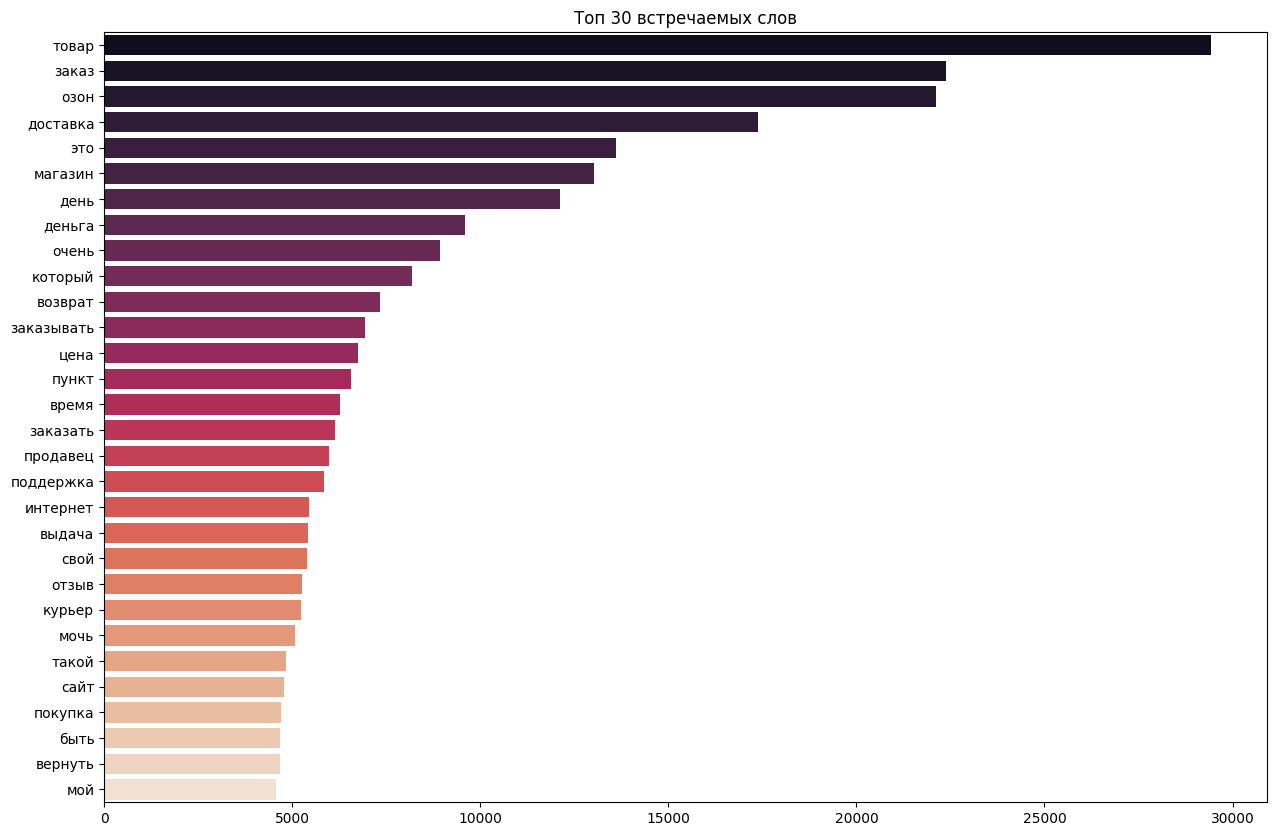

In [125]:
plt.figure(figsize=(15, 10))
sns.barplot(y=words, 
            x=count, 
            orient='h', 
            palette='rocket')

plt.title('Топ 30 встречаемых слов')
plt.show()

В топ-30 часто встречаемых слов нет слов с резко негативным/позитивным окрасом в отрыве от контекста.

Облако часто встречаемых слов

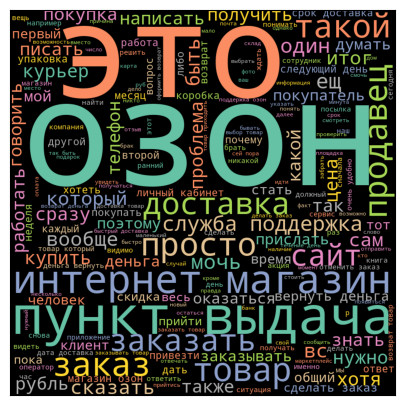

In [79]:
all_tokens = ' '.join(token_string for token_string in df.Tokens)
generate_wordcloud(all_tokens)

- По результатам EDA можно отметить что в датасете преобладают негативные отзывы, необходимо учитывать стратификацию. 

- Негативные отзывы как правило состоят из большего количества слов, что кажется логичным, человек, довольный опытом покупки отзыв либо не оставляет, либо чаще всего делает это лаконично. Негативные отзывы же длиннее, ввиду того что покупатель старается описать суть проблемы, либо "выплескивает эмоции".
- Средняя длина слова отзыва в позитивном отзыве чуть больше чем в негативном.

- Чаще всего же в данном датасете будут встречаться отзывы, состоящие примерно из сотни слов и порядка 6-7 предложений. Встречаются экстремально объемные отзыва, длина самого большого отзыва ~20000 символов, однако это не составит проблем
при числовом представлении текста как в статитистических моделях, так и эмбеддингах Word2Vec и Bert.

- Среди самых часто встречаемых слов сложно выделить слова, которые в отрыве от контекста несут резко положительный/негативный окрас.